In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
pd.options.mode.chained_assignment = None  # default='warn' - to deal with SettingWithCopyWarning in Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

SEED_NUM = 42
np.random.seed(SEED_NUM)


In [3]:
# data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# sklearn models
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve
from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from __future__ import print_function

import warnings
import time
warnings.filterwarnings("ignore")
%matplotlib inline

In [18]:
"""
Helper functions
"""
# import paths
def plot_learning_curve(model_name, best_model, X, y, score, data_name, cv=5):
    total_sample_size = X.shape[0]
    # Plot the learning curve
    train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, cv=5, scoring=score, n_jobs=-1)

    # Calculate the mean and standard deviation of the training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    train_sample_proportion = train_sizes/total_sample_size*100
    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sample_proportion, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.fill_between(train_sample_proportion, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.plot(train_sample_proportion, train_scores_mean, 'o-', color="r", label="Training F1 Score")
    plt.plot(train_sample_proportion, test_scores_mean, 'o-', color="g", label="Validation F1 Score")
    plt.xlabel('Training Set Size (%)')
    plt.ylabel('F1 Score')
    plt.title(f'{model_name} learning Curve with GridSearchCV')
    plt.legend(loc="best")
    plt.grid(True)
    plt.savefig(f'src/{data_name}_output/learning_curve/{model_name}_learning_curve.png')
    plt.show()

def plot_roc(model_name, best_model, X_test, y_test, data_name):
    # Predict probabilities for the test data
    y_prob = best_model.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Calculate the Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig(f'src/{data_name}_output/ROC_curve/{model_name}_ROC.png')

def base_model_runs(X_train, y_train, X_test, y_test):
    algorithms = [DecisionTreeClassifier(),KNeighborsClassifier(),SVC(probability=True),GradientBoostingClassifier(), MLPClassifier()]
    algorithm_names = ["DecisionTreeClassifier","KNeighborsClassifier","SVC","GradientBoostingClassifier", "MLPClassifier"]
    # main hyperparameter tuning step
    for i in range(0, len(algorithms)):
        start_time = time.process_time()
        print("################   %s   ################" %algorithm_names[i])
        clf = algorithms[i]
        clf.fit(X_train, y_train)
        end_time = time.process_time()
        print(f'fit time: {round(end_time - start_time,3)}')
        y_pred = clf.predict(X_test)
        score = f1_score(y_test, y_pred)
        print(f'f1_score: {round(score,3)}')


def model_tuning(X_train, y_train, X_test, y_test, scores, data_name, verbose = False):
    
    # initialisation
    train_report_column_names = ['model', 'Scoring metric', 'Hyperparameters', 'Mean score (validation)', 'Std score (validation)', 'Mean wall clock time']
    validation_report_column_names = ['model', 'Score', 'Best hyperparameters', 'Test score', 'Best refit time']

    train_validation_report = pd.DataFrame(columns=train_report_column_names)
    test_report = pd.DataFrame(columns=validation_report_column_names)

    # Parameters to be tuned. 
    tuned_parameters = [[{'criterion': ["gini", "entropy"],'class_weight': ['balanced'], 'max_depth' : [10,100,1000,10000], 'min_samples_split' : [2,10,100], 'min_samples_leaf': [1,5,10], 'max_features' : ["sqrt","log2"]}],
                        [{'n_neighbors' : [5,10,15,20],'weights': ['distance'], 'algorithm' : ['ball_tree', 'kd_tree', 'brute'],'p' : [1,2,3]}],
                        [{'kernel': ['linear','rbf','sigmoid','poly'], "C": [1.0, 2, 4, 5]}],
                        [{'n_estimators': [100,150,200,250], 'learning_rate' : [0.1,0.05,0.2], 'max_features' : ['sqrt']}],
                        [{'hidden_layer_sizes': [(100,), (100,50), (100,25), (100,50,25)], 'activation': ['tanh'], 'learning_rate_init': [0.01,0.05], 'learning_rate': ['constant', 'adaptive']}]
                        ]
    
    algorithms = [DecisionTreeClassifier(),KNeighborsClassifier(),SVC(probability=True),GradientBoostingClassifier(), MLPClassifier()]
    algorithm_names = ["DecisionTreeClassifier","KNeighborsClassifier","SVC","GradientBoostingClassifier", "MLPClassifier"]

    # main hyperparameter tuning step
    for i in range(0, len(algorithms)):
        print("################   %s   ################" %algorithm_names[i])
        # scores = ['accuracy','precision_macro','recall_macro', 'f1']
        model_list = []
        score_list = []
        mean_score_list = []
        std_score_list = []
        params_list = []
        wall_clock_list = []
        for score in scores:
            print("# Tuning hyper-parameters for %s" % score)
            print()

            clf = GridSearchCV(algorithms[i], tuned_parameters[i], cv=5,
                            scoring='%s' % score)
            clf.fit(X_train, y_train)
            if verbose:
                print("Best parameters set found on development set:")
                print()
                print(clf.best_params_)
                print()
                print("Grid scores on development set:")
                print()
            means = clf.cv_results_['mean_test_score']
            stds = clf.cv_results_['std_test_score']
            wall_clock_times = clf.cv_results_['mean_fit_time']
            for mean, std, wall_clock_time, params in zip(means, stds, wall_clock_times, clf.cv_results_['params']):
                model_list.append(algorithm_names[i])
                score_list.append(score)
                mean_score_list.append(round(mean,3))
                std_score_list.append(round(std,3))
                params_list.append(params)
                wall_clock_list.append(wall_clock_time)
                if verbose:
                    print("%0.3f (+/-%0.03f) for %r"
                    % (mean, std * 2, params))
            if verbose:
                print()

                print("Detailed classification report:")
                print()
                print("The model is trained on the full development set.")
                print("The scores are computed on the full evaluation set.")
                print()
            y_true, y_pred = y_test, clf.predict(X_test)

            if verbose:
                print(classification_report(y_true, y_pred))
                print("Detailed confusion matrix:")
                print(confusion_matrix(y_true, y_pred))
                print("Precision Score: \n")
                print(precision_score(y_true, y_pred))
                print()
            
            # generate test report
            test_df = pd.DataFrame(np.column_stack([algorithm_names[i], score, clf.best_params_, clf.score(X_test, y_test), clf.refit_time_]), columns=validation_report_column_names)
            test_report = pd.concat([test_report, test_df])
            
            # plot learning curve
            plot_learning_curve(model_name=algorithm_names[i], best_model=clf.best_estimator_, X = X_train, y=y_train, data_name=data_name, score=score)

            # plot ROC curve
            plot_roc(model_name=algorithm_names[i], best_model=clf, X_test=X_test, y_test=y_test, data_name=data_name)

            # save classification report
            # Generate the classification report
            report = classification_report(y_true, y_pred)

            # Specify the file path where you want to save the report
            file_path = f"src/{data_name}_output/classification_report/{algorithm_names[i]}_classification_report.txt"

            # Write the classification report to the file
            with open(file_path, "w") as file:
                file.write(report)
        
        # generate train_validation_report
        report_df = pd.DataFrame(np.column_stack([model_list, score_list, params_list, mean_score_list, std_score_list, wall_clock_list]), columns=train_report_column_names).sort_values(by='Mean score (validation)', ascending=False).head()
        train_validation_report = pd.concat([train_validation_report, report_df])

        # save train_report
        train_validation_report.to_csv(f'src/{data_name}_output/model_perf/{algorithm_names[i]}_train_validation_report.csv')

        # save test_report
        test_report.to_csv(f'src/{data_name}_output/model_perf/{algorithm_names[i]}_test_report.csv')
    return train_validation_report, test_report

In [5]:
""" helper function for plotting validation curve """
def plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name, param_range):
    train_scores, test_scores = validation_curve(
        model, X_train, y_train, param_name=param_name, param_range=param_range,
        scoring=score_metric, cv=5, n_jobs=-1)
    
    # Calculate the mean and standard deviation of the scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    best_test_score = np.max(test_scores_mean)
    best_test_index = np.argmax(test_scores_mean)

    if type(param_range[0]) is tuple:
        param_range = np.array([str(t) for t in param_range])
        
    # Plot the validation curve
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel(x_lab)
    plt.ticklabel_format(style='scientific', axis='both')
    plt.ylabel(y_lab)
    plt.plot(param_range, train_scores_mean, label="Training Score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.plot(param_range, test_scores_mean, label="Validation Score", color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.axvline(x=param_range[best_test_index], color='r', linestyle='--')
    plt.annotate(f'Optimal {param_name}: {param_range[best_test_index]}', (param_range[best_test_index], best_test_score), xytext=(10, 20),
            textcoords='offset points', arrowprops={'arrowstyle': '->', 'color': 'r'})

    plt.legend(loc="best")
    plt.grid(True)
    plt.savefig(f'src/{data_name}_output/validation_curve/{model_name}_{param_name}_{score_metric}.png')
    plt.close()

## 1. weather dataset
https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

This dataset contains about 10 years of daily weather observations from many locations across Australia.

RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.

In [20]:
# ----------------------------------------------------------------------- #
# Import required modules
# ----------------------------------------------------------------------- #

# import libraries
import os
import wget
import sqlite3
import numpy as np
import pandas as pd
import functools
import pickle
import json

from typing import Any, Dict
from abc import ABC, abstractmethod

# preprocessing libraries
from sklearn.preprocessing import OneHotEncoder

pd.options.mode.chained_assignment = None  # default='warn' - to deal with SettingWithCopyWarning in Pandas

# required variables from config file
from config import FILE_PATH, PROJECT_PATH, OUTPUT_PATH, DATA_PATH, MODEL_PATH, PREDICTION_PATH, METRICS_PATH
from config import COLS_TO_DROP, COLS_TO_UPPERCASE, COLS_TO_OH

# ----------------------------------------------------------------------- #
# File read methods
# ----------------------------------------------------------------------- #

def read_db_local_path(file_path:str = FILE_PATH, test_connection:bool = True) -> pd.DataFrame:
    """ reads db file from the local path provided
    Parameters
    ----------
    file_path (optional) : str
        Path to the db file stored locally
    test_connection (optional) : bool
        True if we would like to test the connection
        
    Returns
    -------
    pd.DataFrame
        A pandas dataframe containing the returned file
    """
    conn = sqlite3.connect(file_path)
    df = pd.read_sql_query("SELECT * FROM fishing", conn)
    if test_connection:
        if df.empty:
            print('Imported file is empty. Please check.')
        else:
            print('Read file success!')
    return df

def download_db_from_url(url:str, file_name_loc)->None:
    """
    Downloads database file from url provided.

    Parameters:
    url : str
        url link to the downloadable database
    
    """
    wget.download(url, file_name_loc)
    print()
    print('Download success!')
    
# ----------------------------------------------------------------------- #
# Data processing methods
# ----------------------------------------------------------------------- #
def preprocess_data(df:pd.DataFrame) -> pd.DataFrame:
    """ main pre-processing step
    Steps applied:
    1. remove duplicates
    2. drop unused columns
    3. clean up values such as character to uppercase for consistency, re-define RainToday to be consistent with the definition
    4. perform data imputation that is different for data types
    5. apply feature engineering to add in features such as month (more details documented in apply_FeatureEngineering)

    Parameters
    ----------
    df : pd.DataFrame
        input dataframe
        
    Returns
    -------
    df : pd.DataFrame
        Processsed dataframe
    """    
    # step 1: clean data
    print('------------- Processing data -------------')
    df = remove_dupes(df) # remove duplicates
    # df = to_upper_cols(df, COLS_TO_UPPERCASE) # Pressure col to uppercase
    df = data_imputation(df) # fill null values appropriately
    df = drop_cols(df, COLS_TO_DROP) # drop columns (ColourofBoats)
    # df = clean_RainToday(df) # clean RainToday and RainTomorrow columns
    df = convert_str_to_bool(df, ['RainToday', 'RainTomorrow']) # convert RainToday and RainTomorrow into boolean
    

    # step 2: add new features through feature engineering
    df = apply_FeatureEngineering(df) # more details on feature definitions added is documented in this method

    # step 3: apply one-hot encoding to categorical variables
    df = apply_OneHotEncoding(df, COLS_TO_OH)

    # step 4: data sanity checks
    check_no_dupes(df)
    check_no_nulls(df)
    print('------------- Processing complete -------------')

    # step 5: store processed data into folder
    datastore = DataStore()
    # datastore.put_processed("df_processed.csv", df)
    return df

def check_no_dupes(df:pd.DataFrame) -> bool:
    """ To check pandas DataFrame for duplicated rows
    Parameters
    ----------
    df : pd.DataFrame
        input dataframe
        
    Returns
    -------
    bool : True if no duplicates found, else False
    """
    check = df.isnull().sum().sort_values(ascending=False).sum() == 0
    if check:
        print('No duplicates found. Test passed!')
        return True
    else:
        print('Duplicates found. Test failed, please check!')
        return False

def check_no_nulls(df:pd.DataFrame) -> bool:
    """ To check pandas DataFrame for null values
    Parameters
    ----------
    df : pd.DataFrame
        input dataframe
        
    Returns
    -------
    bool : True if no null values found, else False
    """
    check = df.isnull().sum().sort_values(ascending=False).sum() == 0
    if check:
        print('No null values found. Test passed!')
        return True
    else:
        print(f'{df.isnull().sum().sort_values(ascending=False).sum()} null values found. Test failed, please check!')
        return False

def remove_dupes(df:pd.DataFrame) -> pd.DataFrame:
    """ To remove duplicated rows from input DataFrame. Prints message if verbose is set to true.
    Parameters
    ----------
    df : pd.DataFrame
        input dataframe
    -------
    df : pd.DataFrame
        cleaned dataframe without duplicates
    """
    return df[~df.duplicated()]
    

def drop_cols(df:pd.DataFrame, cols_to_drop:list()) -> pd.DataFrame:
    """  To drop specified columns from DataFrame
    Parameters
    ----------
    df : pd.DataFrame
        input dataframe
    cols_to_drop : list(str)
        indicate columns to drop
        
    Returns
    -------
    df : pd.DataFrame
        DataFrame with dropped columns
    """
    return df.drop(columns=cols_to_drop, axis=1)


def to_upper_cols(df:pd.DataFrame, cols_to_upper: list()) -> pd.DataFrame:
    """ To convert all columns defined in cols_to_upper to uppercase
    Parameters
    ----------
    df : pd.DataFrame
        input dataframe
    cols_to_drop : list(str)
        indicate columns to drop
        
    Returns
    -------
    df : pd.DataFrame
        DataFrame with dropped columns
    """
    for col in cols_to_upper:
        df[col] = [p.upper() if p != None else p for p in df[col]]
    return df

def data_imputation(df:pd.DataFrame) -> pd.DataFrame:
    """  To impute data with the following criteria:
    1. For numerical columns, impute with average value for a given day
    2. For categorical columns, fill forward assuming the weather conditions across Singapore is similar across day/location
    
    Parameters
    ----------
    df : pd.DataFrame
        input dataframe
        
    Returns
    -------
    df : pd.DataFrame
        Cleaned dataframe without 
    """
    float_cols = ['Cloud3pm','Cloud9am','Evaporation','WindGustSpeed','Sunshine','Humidity3pm','Humidity9am', 'WindSpeed3pm', 'WindSpeed9am']
    for col in float_cols:
        df[col] = df[['Date',col]].groupby("Date").transform(lambda x: x.fillna(x.mean()))[[col]]

    df = df.sort_values(['Date', 'Location']).fillna(method="ffill")
    return df

def clean_RainToday(df:pd.DataFrame) -> pd.DataFrame:
    """ There are some errors in the RainToday variable. Specifically, some rows with RainToday == 'Yes' AND Rainfall < 1.0mm
    This does not match my understanding of the definition of rain, which is "said to have rained if there is more than 1.0 mm of rain in the day."
    This function will re-compute the values for RainToday using the values of Rainfall
    
    Parameters
    ----------
    df : pd.DataFrame
        input dataframe
        
    Returns
    -------
    df_clean : pd.DataFrame
        Cleaned dataframe with the correct RainToday computations    
    """
    df['RainToday'] = ['Yes' if rf > 1.0 else 'No' for rf in df['Rainfall']]

    # separate the dataframe into 4 different location
    df_changi = df[df['Location'] == 'Changi'].sort_values(['Location', 'Date'])
    df_sentosa = df[df['Location'] == 'Sentosa'].sort_values(['Location', 'Date'])
    df_tuas = df[df['Location'] == 'Tuas'].sort_values(['Location', 'Date'])
    df_wood = df[df['Location'] == 'Woodlands'].sort_values(['Location', 'Date'])

    # check that the data is filtered correctly
    assert df.shape[0] == (df_changi.shape[0] + df_sentosa.shape[0] + df_tuas.shape[0] + df_wood.shape[0])

    # update RainTomorrow by shifting the rows by 1 (only row 1 to 2nd last row is updated)
    df_changi['RainTomorrow'].iloc[:-1] = df_changi['RainToday'].shift(-1).iloc[:-1]
    df_sentosa['RainTomorrow'].iloc[:-1] = df_sentosa['RainToday'].shift(-1).iloc[:-1]
    df_tuas['RainTomorrow'].iloc[:-1] = df_tuas['RainToday'].shift(-1).iloc[:-1]
    df_wood['RainTomorrow'].iloc[:-1] = df_wood['RainToday'].shift(-1).iloc[:-1]

    # join back the rows as df_clean
    df_clean = pd.concat([df_changi, df_tuas, df_sentosa, df_wood])

    # check that there are similar rows in the new data vs old data
    assert df_clean.shape[0] == df.shape[0]

    return df_clean

def convert_str_to_bool(df:pd.DataFrame, cols_to_convert:list()) -> pd.DataFrame:
    """ To convert string columns to boolean type
    Parameters
    ----------
    df : pd.DataFrame
        input dataframe
    
    cols_to_convert : list(str)
        columns to convert from string to boolean

    Returns
    -------
    df : pd.DataFrame
        Dataframe with boolean types as specified
    """
    for col in cols_to_convert:
        df[col] = [1 if r == 'Yes' else 0 for r in df[col]]
    return df

def apply_FeatureEngineering(df:pd.DataFrame) -> pd.DataFrame:
    """ To include new features that would be helpful to model training
    Features include:
    1. month: month based on the date column
    2. day_of_week: day of the week based on the date column

    Parameters
    ----------
    df : pd.DataFrame
        input dataframe
        
    Returns
    -------
    df : pd.DataFrame
        Dataframe with new features as specified
     """
    #  add in day_of_week and month
    df['Date'] = pd.to_datetime(df['Date'])
    df['day_of_week'] = [d.weekday() for d in df['Date']]
    df['month'] = [int(d.strftime("%m")) for d in df['Date']]

    cols = ['Rainfall','Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'Humidity9am', 'Cloud9am', 'RainToday']
    new_names = {col: col + '_prev' for col in cols}

    df_prev = df.groupby('Location')[cols].\
        rolling(window=7, min_periods=1).\
            mean().reset_index(drop=True).\
                rename(columns=new_names).reset_index()

    df_new = pd.concat([df.reset_index(), df_prev], axis = 1)

    return df_new


def apply_OneHotEncoding(df:pd.DataFrame, cols_to_oh:list()) -> pd.DataFrame:
    """ To apply one-hot encoding to the columns in cols_to_oh
    parameters
    ----------
    df : pd.DataFrame
        input dataframe

    cols_to_oh : list(str)
        columns to apply one-hot encoding to
        
    Returns
    -------
    df : pd.DataFrame
        Dataframe with new one-hot encoding features added
    """
    # apply one hot encoding
    ohe = OneHotEncoder(categories='auto') 
    feature_arr = ohe.fit_transform(df[cols_to_oh]).toarray() # array after applying one-hot
    feature_labels = ohe.get_feature_names_out(cols_to_oh) # feature names used for one-hot
    df_hot_encoded = pd.DataFrame(feature_arr, columns=feature_labels).reset_index() # create dataframe based on the array and feature names

    # special column WindGustDir to be transformed differently
    df['WindGustDir_N'] = [1 if 'N' in dir else 0 for dir in df['WindGustDir']]
    df['WindGustDir_S'] = [1 if 'S' in dir else 0 for dir in df['WindGustDir']]
    df['WindGustDir_E'] = [1 if 'E' in dir else 0 for dir in df['WindGustDir']]
    df['WindGustDir_W'] = [1 if 'W' in dir else 0 for dir in df['WindGustDir']]

    # drop one-hot encoded columns
    df_dropped = df.drop(columns = cols_to_oh).reset_index()
    
    # combine both dataframes
    df_new = pd.concat([df_dropped, df_hot_encoded], axis=1)
    
    return df_new

# ----------------------------------------------------------------------- #
# Store data/model paths and helper methods
# ----------------------------------------------------------------------- #
class InvalidExtension(Exception):
    pass

class Classifier(ABC):
    """
    Base estimator class built using Abstract Base Classes.
    Three methods defined (we can potentially add on more methods in the future if needed):
    1. train: trains ML model 
    2. evaluate: evaluate performance of ML model using the test dataset
    3. predict: performs model prediction
    """
    @abstractmethod
    def train(self, *params) -> None:
        pass

    @abstractmethod
    def evaluate(self, *params) -> Dict[str, float]:
        pass

    @abstractmethod
    def predict(self, *params) -> np.ndarray:
        pass

def _check_filepath(ext):
    """ Wrapper function that helps check validity of filepath """
    def _decorator(f):
        @functools.wraps(f)
        def _wrapper(*args, **kwargs):
            filepath = kwargs.get("filepath")
            if not filepath:
                filepath = args[1]

            if not filepath.endswith(ext):
                raise InvalidExtension(f"{filepath} has invalid extension, want {ext}")

            return f(*args, **kwargs)

        return _wrapper

    return _decorator

class Path:
    """
    Helper function that helps get and pull files from respective folders.
    There are two types of methods defined here:
    1. get_(file_type): returns Dataframe/model.pkl based on the path defined
    2. put_(file_type): stores file on the path defined
    """
    project_path = PROJECT_PATH
    processed_data_path = DATA_PATH
    model_path = MODEL_PATH
    output_path = OUTPUT_PATH
    prediction_path = PREDICTION_PATH
    metrics_path = METRICS_PATH

    @_check_filepath(".csv")
    def get_csv(self, filepath: str, **kwargs) -> pd.DataFrame:
        return pd.read_csv(filepath, **kwargs)

    @_check_filepath(".csv")
    def put_csv(self, filepath: str, df: pd.DataFrame, **kwargs) -> None:
        if not isinstance(df, pd.DataFrame):
            raise TypeError(f"df must be of type pd.DataFrame, got {type(df)}")
        df.to_csv(filepath, index=False, **kwargs)

    @_check_filepath(".pkl")
    def get_pkl(self, filepath: str) -> Any:
        with open(filepath, "rb") as f:
            return pickle.load(f)

    @_check_filepath(".pkl")
    def put_pkl(self, filepath: str, python_object: Any) -> None:
        if not python_object:
            raise TypeError("python_object must be non-zero, non-empty, and not None")
        with open(filepath, "wb") as f:
            pickle.dump(python_object, f)

    @_check_filepath(".json")
    def get_json(self, filepath: str) -> Dict:
        with open(filepath, "r") as f:
            return json.load(f)

    @_check_filepath(".json")
    def put_json(self, filepath: str, dic: Dict) -> None:
        if not isinstance(dic, dict):
            raise TypeError(f"dic must be of type dict, got {type(dic)}")
        with open(filepath, "w") as f:
            json.dump(dic, f)
    
class DataStore(Path):
    """ Using path base class, DataStore has a list of helper function that conveniently stores/returns data """
    @_check_filepath(".csv")
    def get_processed(self, filepath: str, **kwargs) -> pd.DataFrame:
        filepath = os.path.join(self.processed_data_path, filepath)
        return self.get_csv(filepath, **kwargs)

    @_check_filepath(".csv")
    def put_processed(self, filepath: str, df: pd.DataFrame, **kwargs) -> None:
        filepath = os.path.join(self.processed_data_path, filepath)
        self.put_csv(filepath, df, **kwargs)

    def get_model(self, filepath: str) -> Classifier:
        filepath = os.path.join(self.model_path, filepath)
        return self.get_pkl(filepath)

    def put_model(self, filepath: str, model: Classifier) -> None:
        filepath = os.path.join(self.model_path, filepath)
        self.put_pkl(filepath, model)

    def get_metrics(self, filepath: str) -> Dict[str, float]:
        filepath = os.path.join(self.metrics_path, filepath)
        return self.get_json(filepath)

    def put_metrics(self, filepath: str, metrics: Dict[str, float]) -> None:
        filepath = os.path.join(self.metrics_path, filepath)
        self.put_json(filepath, metrics)

    def get_predictions(self, filepath: str, **kwargs) -> pd.DataFrame:
        filepath = os.path.join(self.prediction_path, filepath)
        return self.get_csv(filepath, **kwargs)

    def put_predictions(self, filepath: str, df: pd.DataFrame, **kwargs) -> None:
        filepath = os.path.join(self.prediction_path, filepath)
        self.put_csv(filepath, df, **kwargs)


In [41]:
df = pd.read_csv('src/data/weather/weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [47]:
df['RainTomorrow'].value_counts()

0    9034
1    2781
Name: RainTomorrow, dtype: int64

In [21]:
df = pd.read_csv('src/data/weather/processed_weather.csv')
df = df.iloc[:,2:]
df.drop(['index.2','index.1','Date'], axis=1, inplace=True)
df.head()

,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindSpeed9am,Humidity9am,Cloud9am,RainToday,RainTomorrow,AverageTemp,day_of_week,month,Rainfall_prev,Evaporation_prev,Sunshine_prev,WindGustSpeed_prev,WindSpeed9am_prev,Humidity9am_prev,Cloud9am_prev,RainToday_prev,AverageTemp_prev,WindGustDir_N,WindGustDir_S,WindGustDir_E,WindGustDir_W,Location_Changi,Location_Sentosa,Location_Tuas,Location_Woodlands,Pressure9am_HIGH,Pressure9am_LOW,Pressure9am_MED
0,0.0,1.4,9.5,WNW,26.0,6.0,81.0,0.0,0,0,29.6,1,7,0.00,1.400000,9.500000,26.0,6.000000,81.00,0.000000,0.0,29.600000,1,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,2.0,9.8,W,30.0,15.0,41.0,0.0,0,0,28.5,2,7,0.00,1.700000,9.650000,28.0,10.500000,61.00,0.000000,0.0,29.050000,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,5.8,9.4,E,22.0,7.0,55.0,1.0,0,0,28.8,3,7,0.00,3.066667,9.566667,26.0,9.333333,59.00,0.333333,0.0,28.966667,0,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.8,1.8,1.1,SW,24.0,9.0,76.0,7.0,0,0,28.7,4,7,0.20,2.750000,7.450000,25.5,9.250000,63.25,2.000000,0.0,28.900000,0,1,0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,2.0,0.3,S,37.0,11.0,81.0,7.0,0,1,28.0,5,7,0.16,2.600000,6.020000,27.8,9.600000,66.80,3.000000,0.0,28.720000,0,1,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
# running undersampling with random permutations
features=['month', 'Rainfall', 'Rainfall_prev', 'Evaporation', 'Evaporation_prev', 
          'Sunshine', 'Sunshine_prev', 'WindGustSpeed', 'WindGustSpeed_prev',
           'Humidity9am', 'Humidity9am_prev', 'Cloud9am', 'Cloud9am_prev', 'AverageTemp', 'AverageTemp_prev',
           'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_E', 'WindGustDir_W',
          'Location_Changi', 'Location_Sentosa', 'Location_Tuas', 'Location_Woodlands',
          'Pressure9am_HIGH', 'Pressure9am_LOW', 'Pressure9am_MED']

y = df["RainTomorrow"]
X = df[features]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = SEED_NUM) # (only used when there is only one dataset)
print('model results before downsampling')
base_model_runs(X_train, y_train, X_test, y_test)

# define the undersampling method
from imblearn.under_sampling import NearMiss
undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
X, y = undersample.fit_resample(X, y)

# randomly sample rows to reduce data size
n_samples = X.shape[0]
indices = np.random.permutation(n_samples)
indices = indices[:10000]
# Choose the same indices for both x and y
X = X[indices]
y = y.iloc[indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = SEED_NUM) # (only used when there is only one dataset)
print('model results before downsampling')
base_model_runs(X_train, y_train, X_test, y_test)


model results before downsampling
################   DecisionTreeClassifier   ################
fit time: 0.122
f1_score: 0.522
################   KNeighborsClassifier   ################
fit time: 0.0
f1_score: 0.552
################   SVC   ################
fit time: 11.137
f1_score: 0.592
################   GradientBoostingClassifier   ################
fit time: 1.824
f1_score: 0.611
################   MLPClassifier   ################
fit time: 31.237
f1_score: 0.638
model results before downsampling
################   DecisionTreeClassifier   ################
fit time: 0.238
f1_score: 0.708
################   KNeighborsClassifier   ################
fit time: 0.002
f1_score: 0.693
################   SVC   ################
fit time: 3.664
f1_score: 0.802
################   GradientBoostingClassifier   ################
fit time: 0.873
f1_score: 0.8
################   MLPClassifier   ################
fit time: 14.642
f1_score: 0.779


In [27]:
df.shape

(11815, 33)

In [22]:
from imblearn.over_sampling import RandomOverSampler

features=['month', 'Rainfall', 'Rainfall_prev', 'Evaporation', 'Evaporation_prev', 
          'Sunshine', 'Sunshine_prev', 'WindGustSpeed', 'WindGustSpeed_prev',
           'Humidity9am', 'Humidity9am_prev', 'Cloud9am', 'Cloud9am_prev', 'AverageTemp', 'AverageTemp_prev',
           'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_E', 'WindGustDir_W',
          'Location_Changi', 'Location_Sentosa', 'Location_Tuas', 'Location_Woodlands',
          'Pressure9am_HIGH', 'Pressure9am_LOW', 'Pressure9am_MED']

y = df["RainTomorrow"]
X = df[features]

print('Shape before upsampling')
print(X.shape)

# upsampling
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_resample(X, y)

print('Shape after upsampling')
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = SEED_NUM) # (only used when there is only one dataset)

Shape before upsampling
(11815, 26)
Shape after upsampling
(18068, 26)


In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

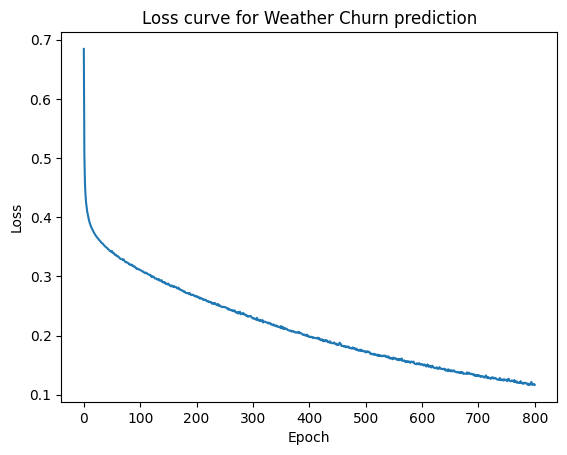

In [31]:
clf = MLPClassifier(max_iter=1000)
clf.fit(X_train, y_train)
# Plot the loss curve
plt.plot(clf.loss_curve_)
plt.title('Loss curve for Weather Churn prediction')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

################   DecisionTreeClassifier   ################
# Tuning hyper-parameters for f1



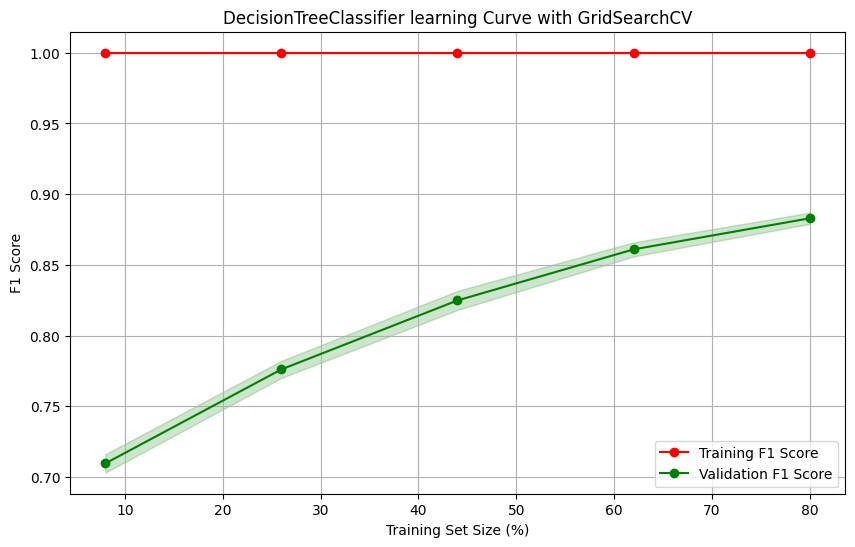

################   KNeighborsClassifier   ################
# Tuning hyper-parameters for f1



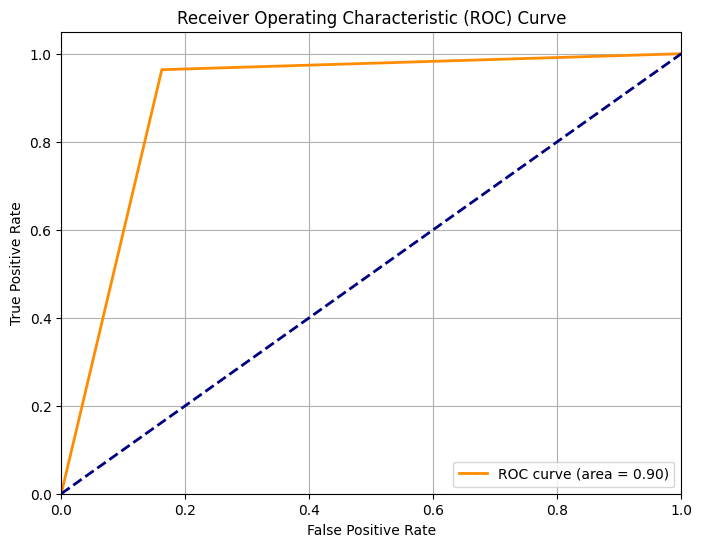

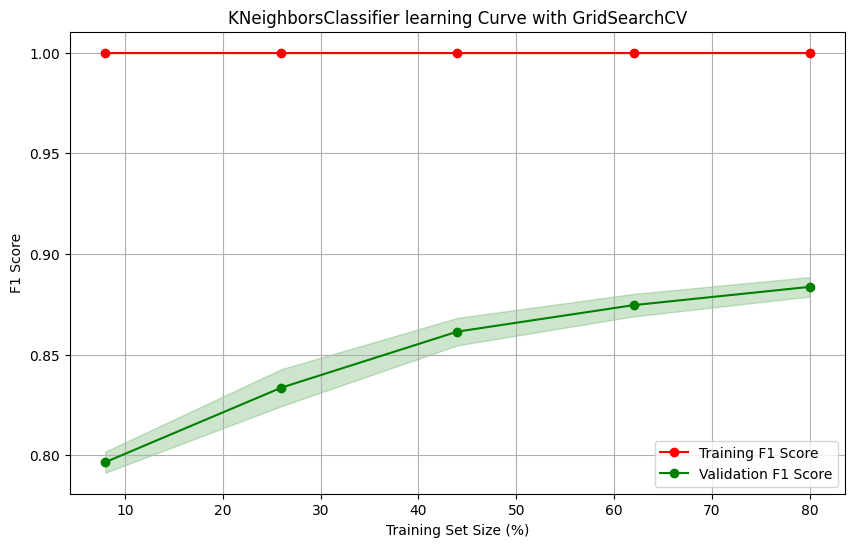

################   SVC   ################
# Tuning hyper-parameters for f1



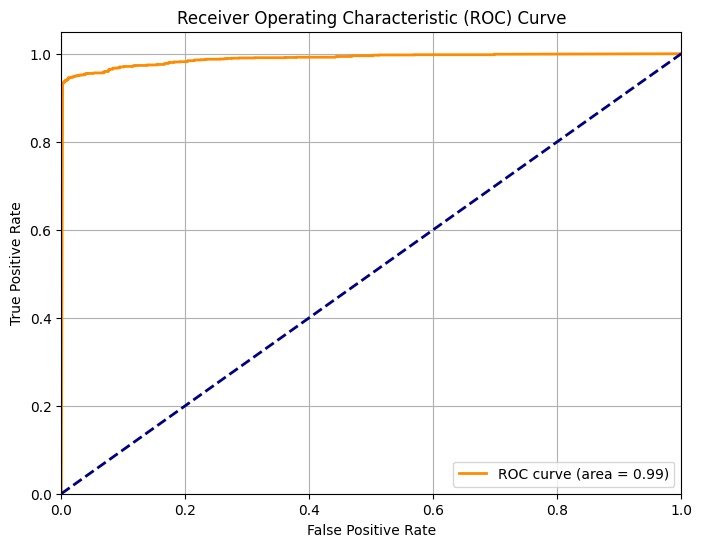

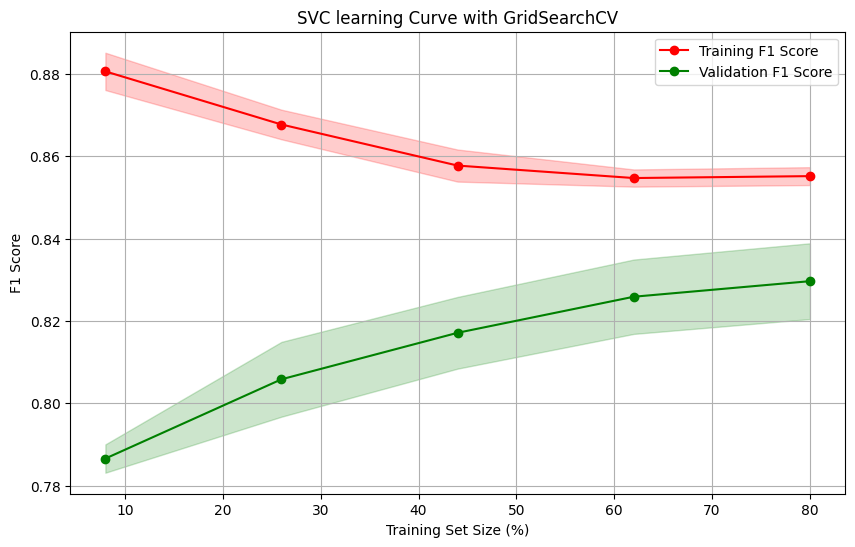

################   GradientBoostingClassifier   ################
# Tuning hyper-parameters for f1



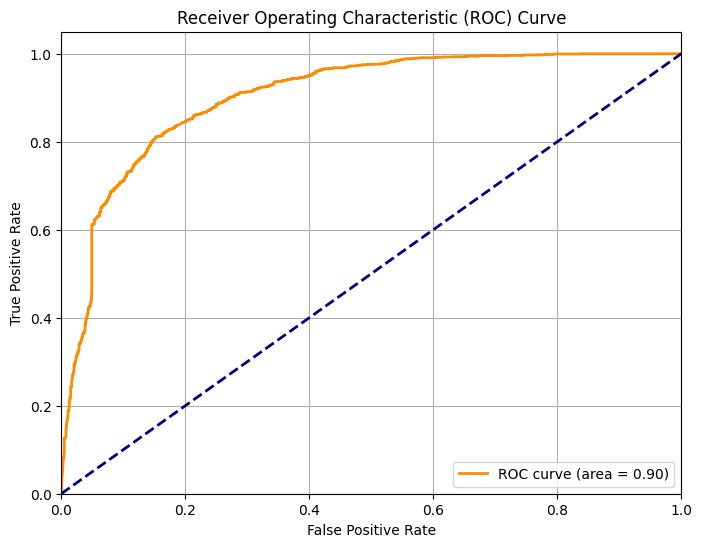

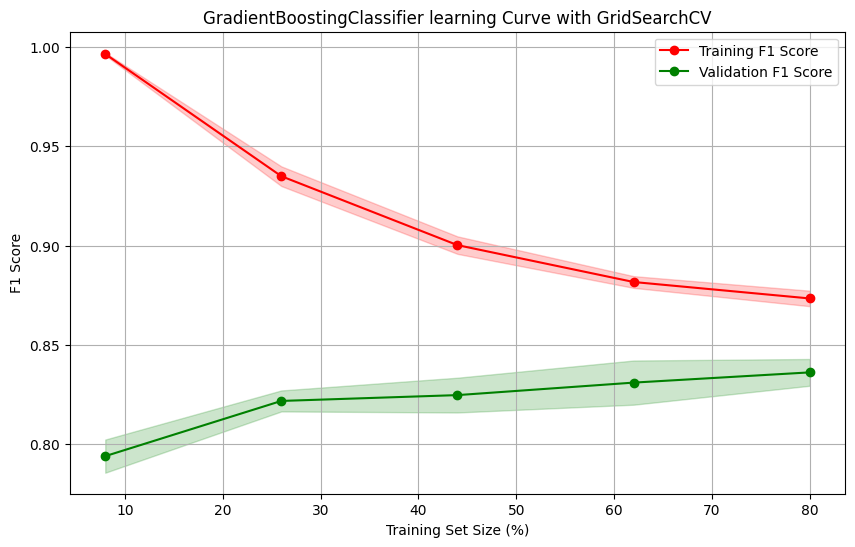

################   MLPClassifier   ################
# Tuning hyper-parameters for f1



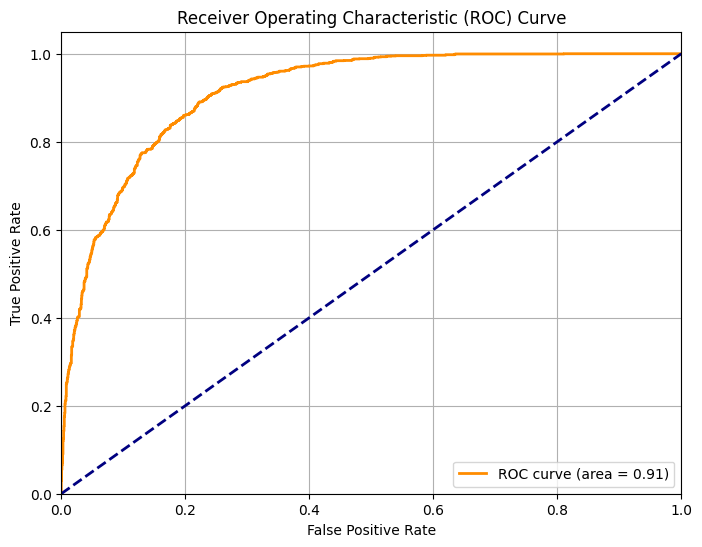

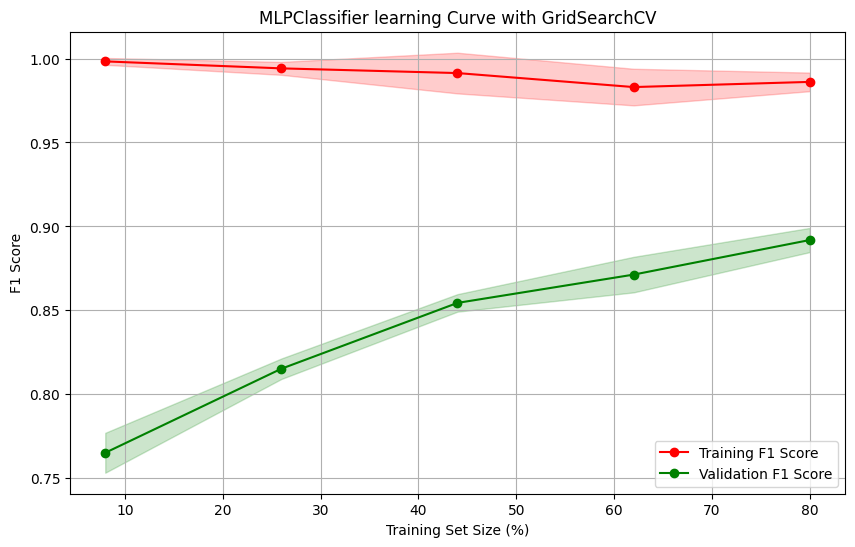

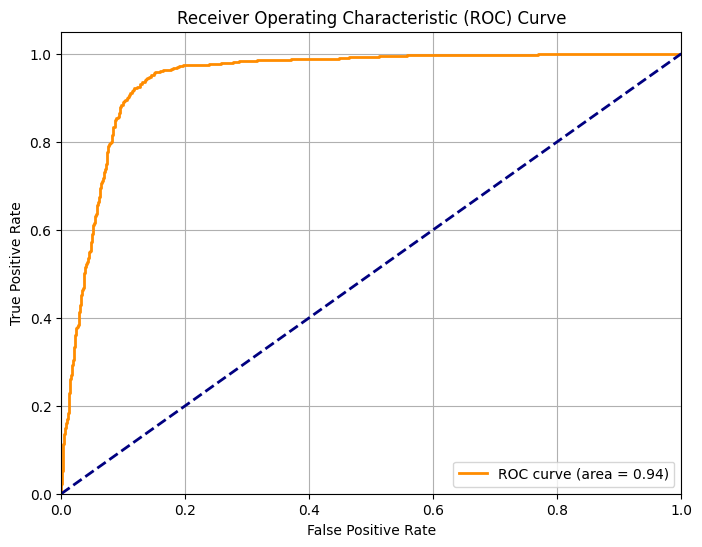

In [53]:
train_validation_report, test_report = model_tuning(X_train = X_train, y_train=y_train, X_test=X_test, y_test=y_test, data_name='weather',scores=['f1'])

In [148]:
""" GB max_depth validation curve """
model_mapping = {'GradientBoostingClassifier': GradientBoostingClassifier(),
                 'KNeighborsClassifier': KNeighborsClassifier(),
                 'SVC': SVC(),
                 'DecisionTreeClassifier': DecisionTreeClassifier(),
                 'MLPClassifier': MLPClassifier()}

data_name = 'weather'
model_name = 'GradientBoostingClassifier'
score_metric = 'f1'
param_name1 = 'n_estimators'
param_range1 = np.arange(10, 500, 10)

title = f'{model_name} validation curve for {param_name1}'
x_lab = f'{param_name1} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name1, param_range1)

""" GB max_depth validation curve """
data_name = 'weather'
model_name = 'GradientBoostingClassifier'
score_metric = 'f1'
param_name2 = 'min_samples_leaf'
param_range2 = np.arange(1, 50, 2)

title = f'{model_name} validation curve for {param_name2}'
x_lab = f'{param_name2} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name2, param_range2)

<class 'numpy.int64'>
<class 'numpy.int64'>


In [149]:
""" KNeighborsClassifier validation curve 1 """
model_mapping = {'GradientBoostingClassifier': GradientBoostingClassifier(),
                 'KNeighborsClassifier': KNeighborsClassifier(),
                 'SVC': SVC(),
                 'DecisionTreeClassifier': DecisionTreeClassifier(),
                 'MLPClassifier': MLPClassifier()}

data_name = 'weather'
model_name = 'KNeighborsClassifier'
score_metric = 'f1'
param_name1 = 'n_neighbors'
param_range1 = np.arange(2, 50, 2)

title = f'{model_name} validation curve for {param_name1}'
x_lab = f'{param_name1} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name1, param_range1)

""" KNeighborsClassifier validation curve 2 """
data_name = 'weather'
model_name = 'KNeighborsClassifier'
score_metric = 'f1'
param_name2 = 'weights'
param_range2 = np.array(['distance', 'uniform'])

title = f'{model_name} validation curve for {param_name2}'
x_lab = f'{param_name2} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name2, param_range2)

<class 'numpy.int64'>
<class 'numpy.str_'>


In [150]:
""" SVC validation curve 1 """
model_mapping = {'GradientBoostingClassifier': GradientBoostingClassifier(),
                 'KNeighborsClassifier': KNeighborsClassifier(),
                 'SVC': SVC(),
                 'DecisionTreeClassifier': DecisionTreeClassifier(),
                 'MLPClassifier': MLPClassifier()}

data_name = 'weather'
model_name = 'SVC'
score_metric = 'f1'
param_name1 = 'C'
param_range1 = np.arange(1, 50, 2)

title = f'{model_name} validation curve for {param_name1}'
x_lab = f'{param_name1} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name1, param_range1)

""" SVC validation curve 2 """
data_name = 'weather'
model_name = 'SVC'
score_metric = 'f1'
param_name2 = 'kernel'
param_range2 = np.array(['rbf', 'linear', 'poly', 'sigmoid'])

title = f'{model_name} validation curve for {param_name2}'
x_lab = f'{param_name2} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name2, param_range2)

<class 'numpy.int64'>
<class 'numpy.str_'>


In [151]:
""" DecisionTreeClassifier validation curve 1 """
model_mapping = {'GradientBoostingClassifier': GradientBoostingClassifier(),
                 'KNeighborsClassifier': KNeighborsClassifier(),
                 'SVC': SVC(),
                 'DecisionTreeClassifier': DecisionTreeClassifier(),
                 'MLPClassifier': MLPClassifier()}

data_name = 'weather'
model_name = 'DecisionTreeClassifier'
score_metric = 'f1'
param_name1 = 'max_depth'
param_range1 = np.arange(1, 50, 2)

title = f'{model_name} validation curve for {param_name1}'
x_lab = f'{param_name1} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name1, param_range1)

""" DecisionTreeClassifier validation curve 2 """
data_name = 'weather'
model_name = 'DecisionTreeClassifier'
score_metric = 'f1'
param_name2 = 'max_features'
param_range2 = np.arange(1, 50, 2)

title = f'{model_name} validation curve for {param_name2}'
x_lab = f'{param_name2} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name2, param_range2)

<class 'numpy.int64'>
<class 'numpy.int64'>


In [152]:
""" MLPClassifier validation curve 1 """
model_mapping = {'GradientBoostingClassifier': GradientBoostingClassifier(),
                 'KNeighborsClassifier': KNeighborsClassifier(),
                 'SVC': SVC(),
                 'DecisionTreeClassifier': DecisionTreeClassifier(),
                 'MLPClassifier': MLPClassifier()}

data_name = 'weather'
model_name = 'MLPClassifier'
score_metric = 'f1'
param_name1 = 'hidden_layer_sizes'
param_range1 = np.array([(100,), (100,50), (100,50,25), (200,), (200,100), (200,100,25)])

title = f'{model_name} validation curve for {param_name1}'
x_lab = f'{param_name1} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name1, param_range1)

""" MLPClassifier validation curve 2 """
data_name = 'weather'
model_name = 'MLPClassifier'
score_metric = 'f1'
param_name2 = 'learning_rate_init'
param_range2 = np.arange(0.001, 0.1, 0.05)

title = f'{model_name} validation curve for {param_name2}'
x_lab = f'{param_name2} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name2, param_range2)

<class 'numpy.str_'>


/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

<class 'numpy.float64'>


In [154]:
""" Examines how epoch changes performance with MLPClassifier """
data_name = 'weather'
model_name = 'MLPClassifier'
score_metric = 'f1'
param_name2 = 'max_iter'
param_range2 = np.arange(1, 1000, 10)

title = f'{model_name} validation curve for {param_name2}'
x_lab = f'{param_name2} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name2, param_range2)

/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reach

<class 'numpy.int64'>


## bank dataset

In [14]:
df = pd.read_csv('src/data/bank/train.csv')


In [15]:
def encoder(df):
    from sklearn.preprocessing import LabelEncoder
    labelencoder = LabelEncoder()
    for col in df.columns:
        if df[col].dtypes=='object':
            df[col]=labelencoder.fit_transform(df[col])
    return df

df=encoder(df)

In [16]:
X = df.drop(columns=['Exited', 'id','CustomerId', 'Surname'])
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df[['Exited']].astype('int')

# define the undersampling method
from imblearn.under_sampling import NearMiss
undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
X, y = undersample.fit_resample(X, y)

# randomly sample rows to reduce data size
n_samples = X.shape[0]
indices = np.random.permutation(n_samples)
indices = indices[:10000]
# Choose the same indices for both x and y
X = X[indices]
y = y.iloc[indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = SEED_NUM) # (only used when there is only one dataset)


In [10]:
X = df.drop(columns=['Exited', 'id','CustomerId', 'Surname'])
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df[['Exited']].astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = SEED_NUM) # (only used when there is only one dataset)
print('model results before downsampling')
base_model_runs(X_train, y_train, X_test, y_test)

# define the undersampling method
from imblearn.under_sampling import NearMiss
undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
X, y = undersample.fit_resample(X, y)

# randomly sample rows to reduce data size
n_samples = X.shape[0]
indices = np.random.permutation(n_samples)
indices = indices[:10000]
# Choose the same indices for both x and y
X = X[indices]
y = y.iloc[indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = SEED_NUM) # (only used when there is only one dataset)
print('model results before downsampling')
base_model_runs(X_train, y_train, X_test, y_test)


model results before downsampling
################   DecisionTreeClassifier   ################
fit time: 0.563
f1_score: 0.53
################   KNeighborsClassifier   ################
fit time: 0.118
f1_score: 0.594
################   SVC   ################
fit time: 2261.323
f1_score: 0.598
################   GradientBoostingClassifier   ################
fit time: 11.276
f1_score: 0.627
################   MLPClassifier   ################
fit time: 91.519
f1_score: 0.635
model results before downsampling
################   DecisionTreeClassifier   ################
fit time: 0.03
f1_score: 0.713
################   KNeighborsClassifier   ################
fit time: 0.005
f1_score: 0.71
################   SVC   ################
fit time: 7.969
f1_score: 0.765
################   GradientBoostingClassifier   ################
fit time: 0.7
f1_score: 0.771
################   MLPClassifier   ################
fit time: 16.978
f1_score: 0.767


################   DecisionTreeClassifier   ################
# Tuning hyper-parameters for f1



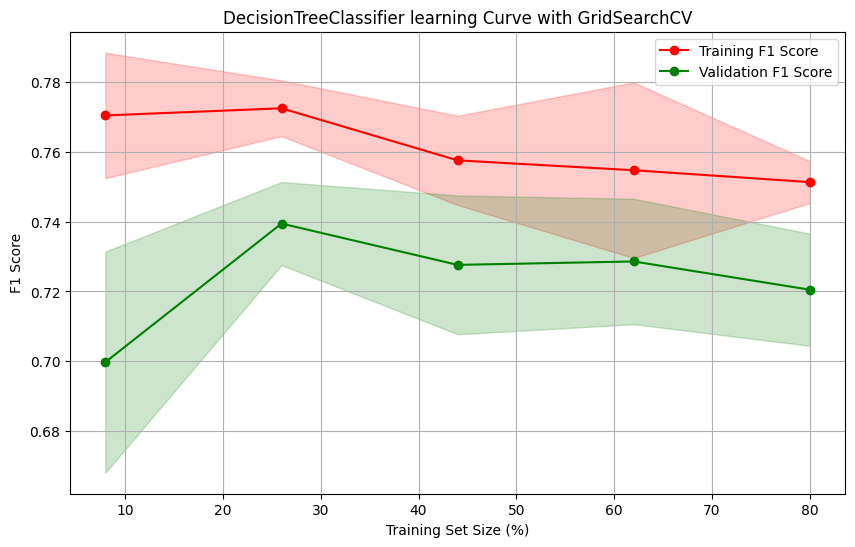

################   KNeighborsClassifier   ################
# Tuning hyper-parameters for f1



/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neighbors/_cla

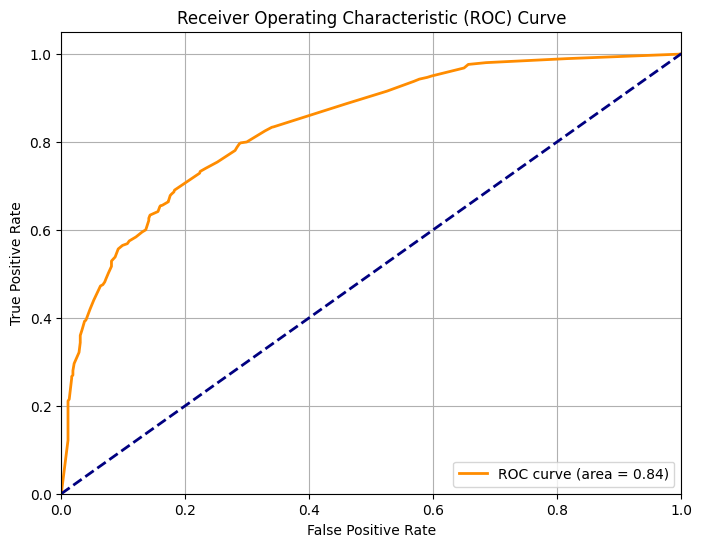

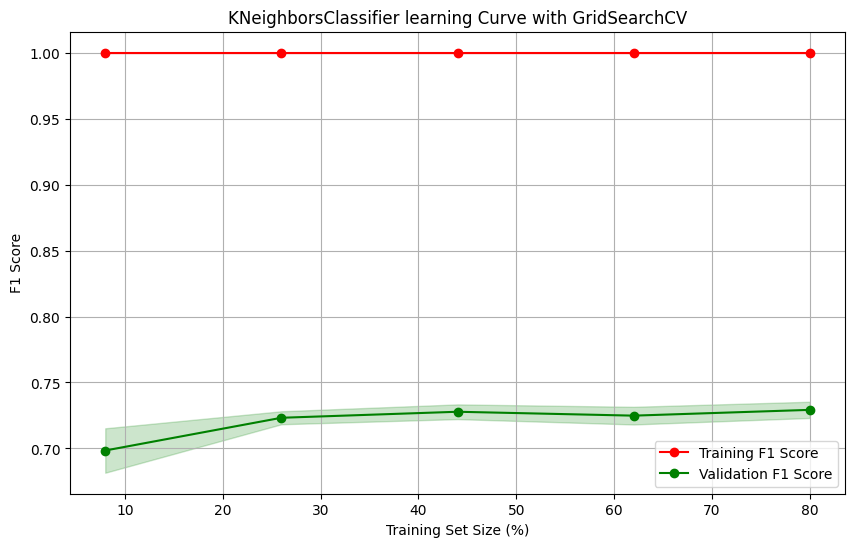

################   SVC   ################
# Tuning hyper-parameters for f1



/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/utils/valid

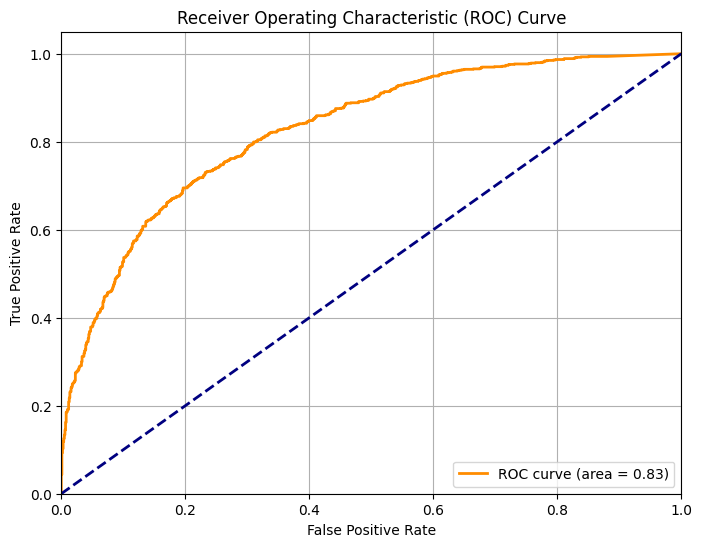

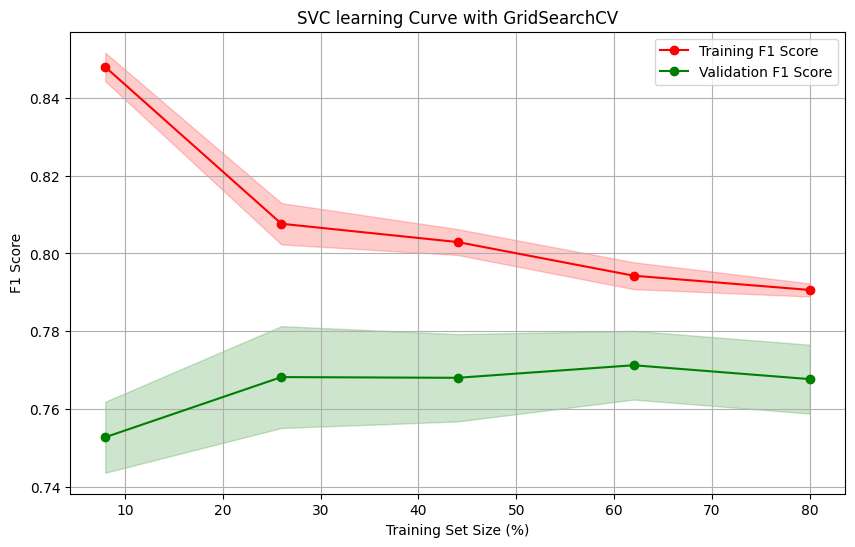

################   GradientBoostingClassifier   ################
# Tuning hyper-parameters for f1



/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataC

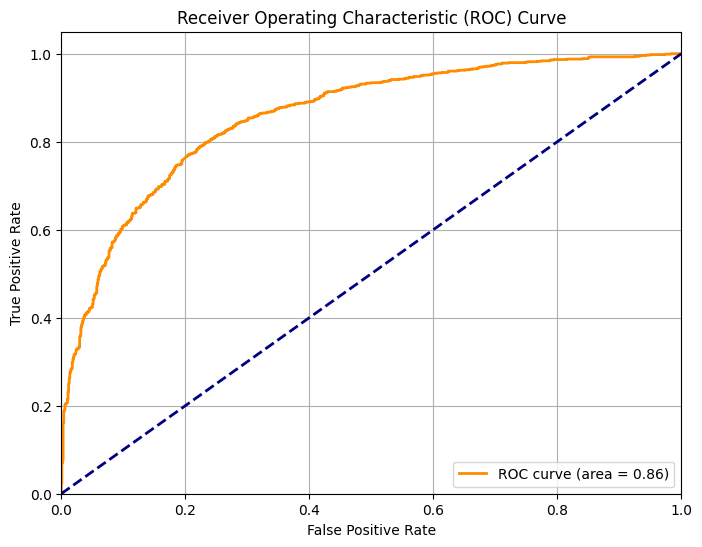

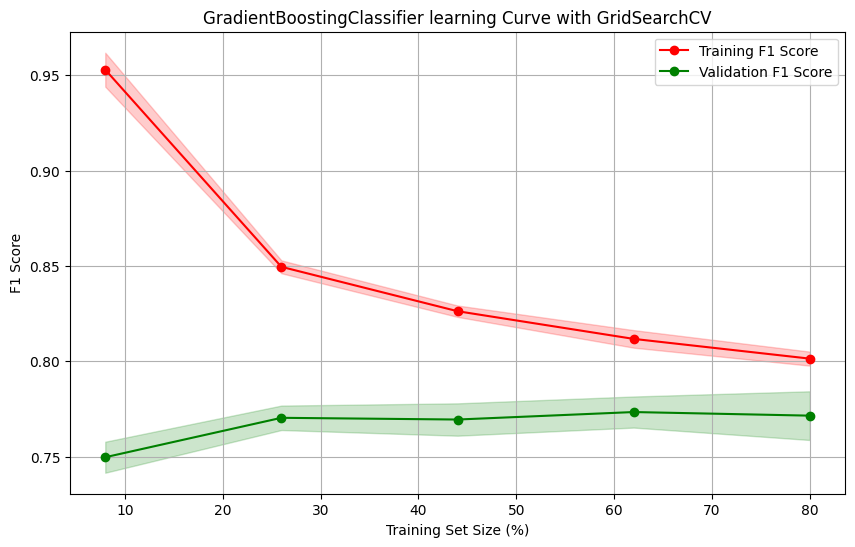

################   MLPClassifier   ################
# Tuning hyper-parameters for f1



/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/a

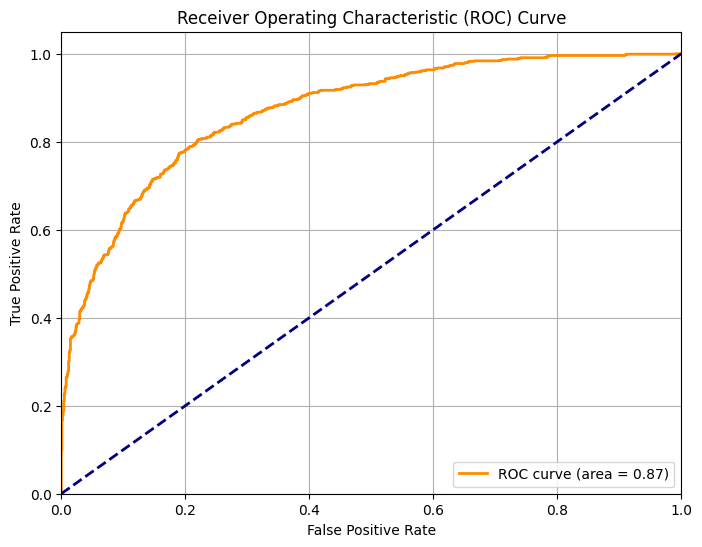

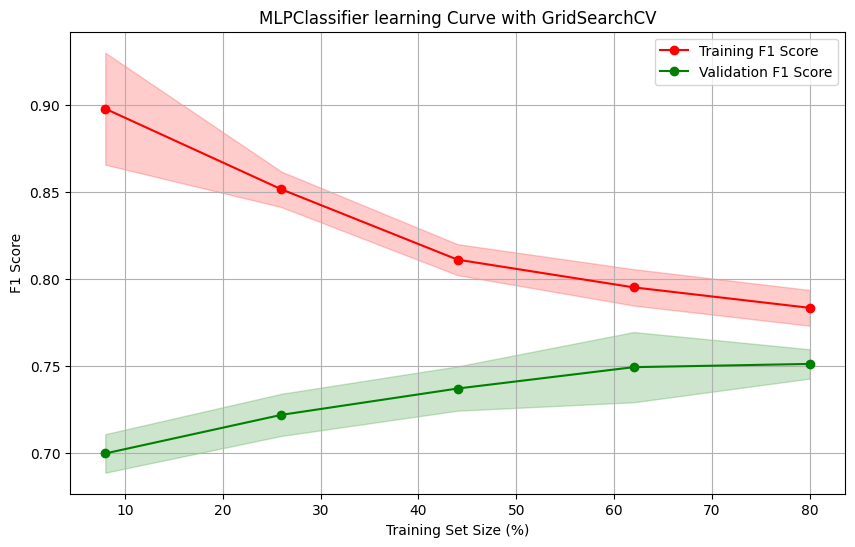

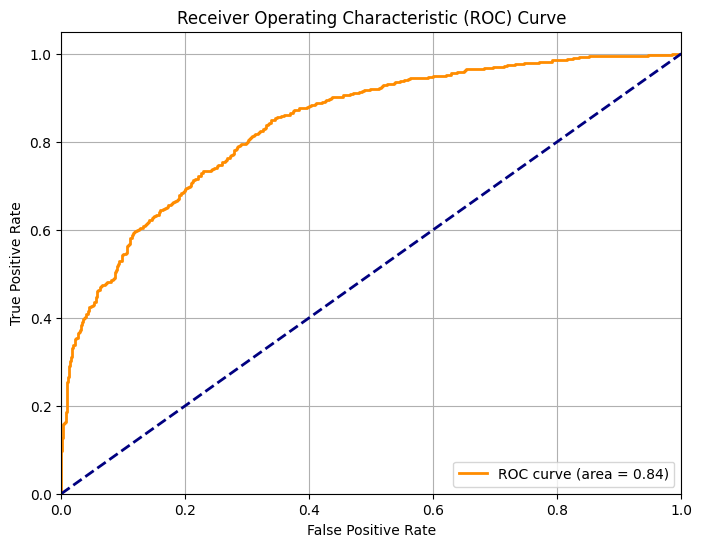

In [19]:
train_validation_report, test_report = model_tuning(X_train = X_train, y_train=y_train, X_test=X_test, y_test=y_test, data_name='bank',scores=['f1'])

In [77]:
""" GB max_depth validation curve """
model_mapping = {'GradientBoostingClassifier': GradientBoostingClassifier(),
                 'KNeighborsClassifier': KNeighborsClassifier(),
                 'SVC': SVC(),
                 'DecisionTreeClassifier': DecisionTreeClassifier(),
                 'MLPClassifier': MLPClassifier()}

data_name = 'bank'
model_name = 'GradientBoostingClassifier'
score_metric = 'f1'
param_name1 = 'n_estimators'
param_range1 = np.arange(10, 500, 10)

title = f'{model_name} validation curve for {param_name1}'
x_lab = f'{param_name1} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name1, param_range1)

""" GB max_depth validation curve """
data_name = 'bank'
model_name = 'GradientBoostingClassifier'
score_metric = 'f1'
param_name2 = 'min_samples_leaf'
param_range2 = np.arange(1, 50, 2)

title = f'{model_name} validation curve for {param_name2}'
x_lab = f'{param_name2} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name2, param_range2)

/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataC

In [78]:
""" KNeighborsClassifier validation curve 1 """
model_mapping = {'GradientBoostingClassifier': GradientBoostingClassifier(),
                 'KNeighborsClassifier': KNeighborsClassifier(),
                 'SVC': SVC(),
                 'DecisionTreeClassifier': DecisionTreeClassifier(),
                 'MLPClassifier': MLPClassifier()}

data_name = 'bank'
model_name = 'KNeighborsClassifier'
score_metric = 'f1'
param_name1 = 'n_neighbors'
param_range1 = np.arange(2, 50, 2)

title = f'{model_name} validation curve for {param_name1}'
x_lab = f'{param_name1} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name1, param_range1)

""" KNeighborsClassifier validation curve 2 """
data_name = 'bank'
model_name = 'KNeighborsClassifier'
score_metric = 'f1'
param_name2 = 'weights'
param_range2 = np.array(['distance', 'uniform'])

title = f'{model_name} validation curve for {param_name2}'
x_lab = f'{param_name2} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name2, param_range2)

/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neighbors/_cla

In [79]:
""" SVC validation curve 1 """
model_mapping = {'GradientBoostingClassifier': GradientBoostingClassifier(),
                 'KNeighborsClassifier': KNeighborsClassifier(),
                 'SVC': SVC(),
                 'DecisionTreeClassifier': DecisionTreeClassifier(),
                 'MLPClassifier': MLPClassifier()}

data_name = 'bank'
model_name = 'SVC'
score_metric = 'f1'
param_name1 = 'C'
param_range1 = np.arange(1, 50, 2)

title = f'{model_name} validation curve for {param_name1}'
x_lab = f'{param_name1} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name1, param_range1)

""" SVC validation curve 2 """
data_name = 'bank'
model_name = 'SVC'
score_metric = 'f1'
param_name2 = 'kernel'
param_range2 = np.array(['rbf', 'linear', 'poly', 'sigmoid'])

title = f'{model_name} validation curve for {param_name2}'
x_lab = f'{param_name2} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name2, param_range2)

/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/utils/valid

In [80]:
""" DecisionTreeClassifier validation curve 1 """
model_mapping = {'GradientBoostingClassifier': GradientBoostingClassifier(),
                 'KNeighborsClassifier': KNeighborsClassifier(),
                 'SVC': SVC(),
                 'DecisionTreeClassifier': DecisionTreeClassifier(),
                 'MLPClassifier': MLPClassifier()}

data_name = 'bank'
model_name = 'DecisionTreeClassifier'
score_metric = 'f1'
param_name1 = 'max_depth'
param_range1 = np.arange(1, 50, 2)

title = f'{model_name} validation curve for {param_name1}'
x_lab = f'{param_name1} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name1, param_range1)

""" DecisionTreeClassifier validation curve 2 """
data_name = 'bank'
model_name = 'DecisionTreeClassifier'
score_metric = 'f1'
param_name2 = 'max_features'
param_range2 = np.arange(1, 50, 2)

title = f'{model_name} validation curve for {param_name2}'
x_lab = f'{param_name2} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name2, param_range2)

In [81]:
""" MLPClassifier validation curve 1 """
model_mapping = {'GradientBoostingClassifier': GradientBoostingClassifier(),
                 'KNeighborsClassifier': KNeighborsClassifier(),
                 'SVC': SVC(),
                 'DecisionTreeClassifier': DecisionTreeClassifier(),
                 'MLPClassifier': MLPClassifier()}

data_name = 'bank'
model_name = 'MLPClassifier'
score_metric = 'f1'
param_name1 = 'hidden_layer_sizes'
param_range1 = np.array([(100,), (100,50), (100,50,25), (200,), (200,100), (200,100,25)])

title = f'{model_name} validation curve for {param_name1}'
x_lab = f'{param_name1} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name1, param_range1)

""" MLPClassifier validation curve 2 """
data_name = 'bank'
model_name = 'MLPClassifier'
score_metric = 'f1'
param_name2 = 'learning_rate_init'
param_range2 = np.arange(0.001, 0.1, 0.05)

title = f'{model_name} validation curve for {param_name2}'
x_lab = f'{param_name2} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name2, param_range2)

/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/a

In [89]:
clf = MLPClassifier(max_iter=1000)
clf.fit(X_train, y_train)

MLPClassifier(max_iter=1000)

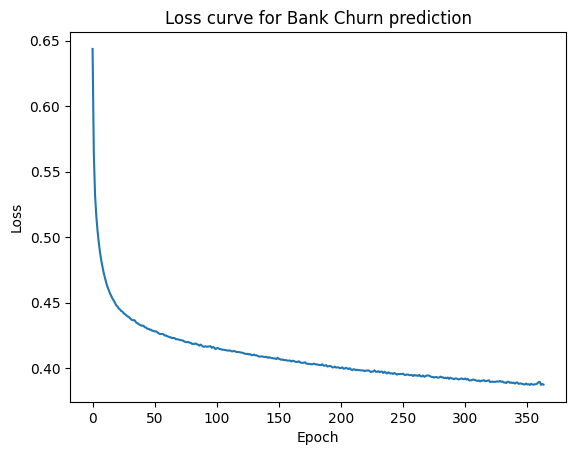

In [122]:
# Plot the loss curve
plt.plot(clf.loss_curve_)
plt.title('Loss curve for Bank Churn prediction')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

<AxesSubplot:>

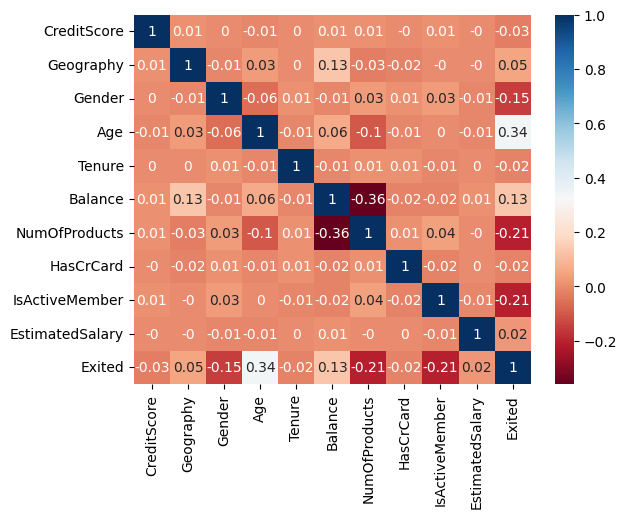

In [121]:
import seaborn as sb

corr = df.drop(columns=['id','CustomerId', 'Surname']).corr().round(2)
sb.heatmap(corr, cmap="RdBu", annot=True)

In [82]:
""" Examines how epoch changes performance with MLPClassifier """
data_name = 'bank'
model_name = 'MLPClassifier'
score_metric = 'f1'
param_name2 = 'max_iter'
param_range2 = np.arange(1, 1000, 10)

title = f'{model_name} validation curve for {param_name2}'
x_lab = f'{param_name2} values'
y_lab = f'{score_metric}'

model = model_mapping[model_name]
best_params = dict(test_report[test_report['model'] == model_name]['Best hyperparameters'][0])
model.set_params(**best_params)

plot_validation_curve(data_name, title, x_lab, y_lab, model_name, model, score_metric, param_name2, param_range2)

/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/aiap_assessment/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelvin/opt/anaconda3/envs/a

KeyboardInterrupt: 